In [1]:
"""  Importing necessary modules/ functions needed for the task  """

import lal
import lalsimulation as ls
import pycbc.types as pt
import matplotlib.pyplot as plt
import matplotlib
import time
import gwnr
import numpy as np
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI
from tqdm import tqdm
from scipy import interpolate
from scipy.interpolate import interp1d
import math
import pycbc.types
from numpy import diff
import pandas as pd
from pycbc.types import TimeSeries
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
import pycbc.types
from pycbc import waveform
import pycbc.types.timeseries as load_pycbc
from lal import PC_SI
import pycbc.conversions as convert
import h5py
import pycbc.waveform as wf
import pycbc.psd as ppsd
import pycbc.filter as filt
from pycbc.waveform import waveform_modes
from pycbc.waveform import frequency_from_polarizations, phase_from_polarizations
import gwnr.waveform.enigma_utils as eu

ModuleNotFoundError: No module named 'gwnr'

In [82]:
""" Calling NR-CATALOG-TOOLS  """

from nrcatalogtools import SXSCatalog
sxscatalog = SXSCatalog.load()
print(sxscatalog.simulations_dataframe.index)

Index(['SXS:BBH:0001', 'SXS:BBH:0002', 'SXS:BBH:0003', 'SXS:BBH:0004',
       'SXS:BBH:0005', 'SXS:BBH:0006', 'SXS:BBH:0007', 'SXS:BBH:0008',
       'SXS:BBH:0009', 'SXS:BBH:0010',
       ...
       'SXS:BBH:2265', 'SXS:NSNS:0001', 'SXS:NSNS:0002', 'SXS:BHNS:0001',
       'SXS:BHNS:0002', 'SXS:BHNS:0003', 'SXS:BHNS:0004', 'SXS:BHNS:0005',
       'SXS:BHNS:0006', 'SXS:BHNS:0007'],
      dtype='object', length=2028)


In [84]:
""" Loading SXS:BBH:1364 to wf variable """

wf=sxscatalog.get('SXS:BBH:1373')

Found the following files to load from the SXS catalog:
    SXS:BBH:1373v5/Lev7/rhOverM_Asymptotic_GeometricUnits_CoM.h5


In [4]:
""" 
Our motivation/ goal is to find the value of parameters (f_ref, e0 ,l0) when the match between IMRESIGMAHM and 
NR simulation is maximized. To do this, we define a function calc_mismatch() which returns the mismatch between 
IMRESIGMAHM and  NR simulation. We then use this function and optimize it over (f_ref, e0 ,l0) to get the lowest
mismatch.

The optimization procedure can be done in two ways,

1. First, to get an idea of the region of the parameter values of (f_ref, e0 ,l0) for which the mismatch 
is tending towards a lower value, we create a set of 100 (or 1000 or 10000) random points of (f_ref, e0 ,l0).
We then use calc_mismatch() and compute mismatches for these 100 (or 1000 or 10000) points and find the point 
among these 100 (or 1000 or 10000) points for which the mismatch is minimum.

2. Next, we use that particular set of value as initial guess/start value in the optimization process.

We can skip to point number (2) if we have already identified the point where the mismatch is minimum.


Below are the values of the parameters used for the computation. Total mass, f_low, and inclination angle (iota)
is fixed to 40 M_sun, 10 Hz, and 60 degrees for all simulations, respectively. Value of q, s1z, s2z, t_ref depends 
on simulations and can be obtained from metadata of the simulation.

"""

M=40
q=2.000
m1=convert.mass1_from_mtotal_q(M,q)
m2=convert.mass2_from_mtotal_q(M,q)
distance=1
f_low=10
s1z = 9.2578017353e-05
s2z = -0.000125733653997
sample_rate=4096
dt=1/sample_rate
conv=(lal.G_SI*lal.MSUN_SI*M/(distance*1e6*lal.PC_SI)/lal.C_SI/lal.C_SI) #conversion factor
modes=[(2,2),(2,-2)]#,(2,1),(2,-1),(3,2),(3,-2),(3,3),(3,-3),(4,4),(4,-4),(4,3),(4,-3)] # modes used for the computation
modes_to_use=[(2,2)]#, (2,1), (3,2),(3,3),(4,4),(4,3)]
iota=np.pi/3 # inclination angle


def calc_mismatch(frefel,verbose=False):
    fref,e,l=frefel
    h_str_NR=0
    for mode in modes:
        
        ell, em=mode
        
        
        tref = 640.0  #check meta-data of NR simulations for tref

        hlm_NR=wf.get_mode(ell,em)

        x1=hlm_NR[:,0]
        y1=hlm_NR[:,1]*(conv)    
        z1=hlm_NR[:,2]*(conv)

        plotband=np.where(x1>=tref)

        x1=x1[plotband]
        x1=x1-x1[0]
        y1=y1[plotband]    
        z1=z1[plotband]


        delta_t_NR = dt

        
               
        Ylm=waveform_modes.get_glm(ell, em, iota)        
    
        hlm_tot_NR=y1+1j*z1
        
        h_str_NR += (hlm_tot_NR*Ylm)
    

    delta_t_common=delta_t_NR
    t=x1*M*MTSUN_SI
    
    hp_NR=h_str_NR.real
    hc_NR=-h_str_NR.imag
    
    # interpolation to sample data at equispaced time points
    
    tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
    hp_NR_sample = interp1d(t,hp_NR,kind='cubic')
    hp_NR_int = hp_NR_sample(tVec_NR)
    hc_NR_sample = interp1d(t,hc_NR,kind='cubic')
    hc_NR_int = hc_NR_sample(tVec_NR)

    
    hpVec_NR = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
    hcVec_NR = TimeSeries(hc_NR_int,delta_t_common,epoch=0)
    
    itime=time.time()
    
    hpl, hcr = eu.get_imr_enigma_waveform(m1, m2, fref, sample_rate, s1z, s2z, e, l, iota, 0, 
                                          distance, verbose=False,f_window_mr_transition=10,
                                          modes_to_use=modes_to_use,
                                          keep_f_mr_transition_at_center=True)
    
    
    tlen = max(len(hpl), len(hpVec_NR))

    hpl.resize(tlen)
    
    hpVec_NR.resize(tlen)

    # Generate the aLIGO ZDHP PSD
    
    delta_f = 1.0 / hpl.duration
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    m, i = match(hpl, hpVec_NR, psd=psd, low_frequency_cutoff=f_low)
    mismatch = 1 - m

    return(mismatch*100)

In [20]:
A=[29.137944187685491, 0.087216814406030, 4.718598086992541]
calc_mismatch(A)

3.05495888955698

In [19]:
import scipy.optimize as opt
bounds=[(11,100),(0.01,0.6),(0,2*np.pi)]
res = opt.minimize(calc_mismatch,x0=[29.137982095127676, 0.087212756711472, 4.718577489607354],bounds=bounds, 
                   method='nelder-mead')
optimal = res.x

formatted_optimal = ", ".join("{:.15f}".format(val) for val in optimal)
print(f"Optimal : [{formatted_optimal}]")

#print(f"Optimal : {optimal:.15f}")
print(f"value : {res.fun}")

Optimal : [29.137944187685491, 0.087216814406030, 4.718598086992541]
value : 3.054958889578363


This mass= 20 is fine
This mass= 21 is fine
This mass= 22 is fine
This mass= 23 is fine
This mass= 24 is fine
This mass= 25 is fine
This mass= 26 is fine
This mass= 27 is fine
This mass= 28 is fine
This mass= 29 is fine
This mass= 30 is fine
This mass= 31 is fine
This mass= 32 is fine
This mass= 33 is fine
This mass= 34 is fine
This mass= 35 is fine
This mass= 36 is fine
This mass= 37 is fine
This mass= 38 is fine
This mass= 39 is fine
This mass= 40 is fine
This mass= 41 is fine
This mass= 42 is fine
This mass= 43 is fine
This mass= 44 is fine
This mass= 45 is fine
This mass= 46 is fine
This mass= 47 is fine
This mass= 48 is fine
This mass= 49 is fine
This mass= 50 is fine
This mass= 51 is fine
This mass= 52 is fine
This mass= 53 is fine
This mass= 54 is fine
This mass= 55 is fine
This mass= 56 is fine
This mass= 57 is fine
This mass= 58 is fine
This mass= 59 is fine
This mass= 60 is fine
This mass= 61 is fine
This mass= 62 is fine
This mass= 63 is fine
This mass= 64 is fine
This mass=

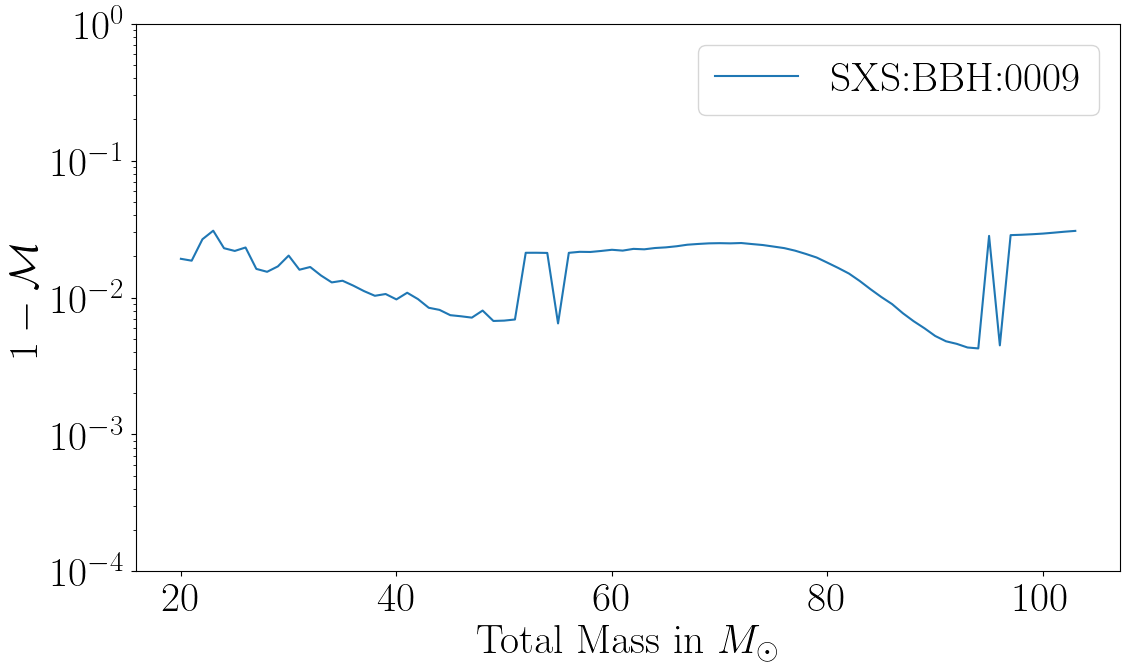

In [31]:
Optimal_val=[29.137944187685491, 0.087216814406030, 4.718598086992541] # optimized values

M_values=np.arange(20,121,1)
q=2.000
m1=convert.mass1_from_mtotal_q(M,q)
m2=convert.mass2_from_mtotal_q(M,q)
distance=1
f_low=10
s1z = 9.2578017353e-05
s2z = -0.000125733653997
#distance=1e6*lal.PC_SI
fref_val=Optimal_val[0]
e_val = Optimal_val[1]
l_val = Optimal_val[2]
sample_rate=4096
dt=1/sample_rate

modes=[(2,2),(2,-2),(2,1),(2,-1),(3,2),(3,-2),(3,3),(3,-3),(4,4),(4,-4),(4,3),(4,-3)] # modes used for the computation
modes_to_use=[(2,2), (2,1), (3,2),(3,3),(4,4),(4,3)]
iota=np.pi/3
m_original=40


Mvalues=[]

"""  
Below we check for which mass values we do not get a Desired frequency out of bound error. We store those
values of mass in Mvalues and use it to generate mismatch vs. total mass figure. 

"""

for mass in M_values:
    m1=convert.mass1_from_mtotal_q(mass,q)
    m2=convert.mass2_from_mtotal_q(mass,q)
    
    try:
        hpl, hcr = eu.get_imr_enigma_waveform(m1, m2, fref_val, sample_rate, s1z, s2z, e_val, l_val, iota, 0, 
                                          distance, verbose=False,f_window_mr_transition=10,
                                              modes_to_use=modes_to_use,
                                             keep_f_mr_transition_at_center=True)
        print("This mass= {} is fine".format(mass))
        Mvalues.append(mass)
    except:
        print("This mass= {} has problem".format(mass))
#print(Mvalues)
    


match_values=[]
mismatch_values=[]

for m_v in Mvalues:
    
    m1=convert.mass1_from_mtotal_q(m_v,q)
    m2=convert.mass2_from_mtotal_q(m_v,q)
    conv=(lal.G_SI*lal.MSUN_SI*m_v/(distance*1e6*lal.PC_SI)/lal.C_SI/lal.C_SI)
    h_str_NR=0
    mass_fac = m_original/m_v # mass_factor to be used to scale f_ref and time step (dt)
    
    #print(m_v)
    
    fref=fref_val*mass_fac # scaling f_ref
    e=e_val
    l=l_val
    
    dt_new= dt*mass_fac  # scaling time step
    
    

    for mode in modes:
        #print(mode)
        ell, em=mode


        tref = 640.0 #check meta-data of NR simulations for tref

        hlm_NR=wf.get_mode(ell,em)

        x1=hlm_NR[:,0]
        y1=hlm_NR[:,1]*(conv)    
        z1=hlm_NR[:,2]*(conv)
        

        plotband=np.where(x1>=tref)

        x1=x1[plotband]
        x1=x1-x1[0]
        y1=y1[plotband]    
        z1=z1[plotband]


        delta_t_NR = dt_new

        
               
        Ylm=waveform_modes.get_glm(ell, em, iota)        
    
        hlm_tot_NR=y1+1j*z1
        
        h_str_NR += (hlm_tot_NR*Ylm)


    delta_t_common=delta_t_NR
    t=x1*m_v*MTSUN_SI

    hp_NR=h_str_NR.real
    hc_NR=-h_str_NR.imag

    #### interpolation to sample data at equispaced time points
    
    tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
    hp_NR_sample = interp1d(t,hp_NR,kind='cubic')
    hp_NR_int = hp_NR_sample(tVec_NR)
    hc_NR_sample = interp1d(t,hc_NR,kind='cubic')
    hc_NR_int = hc_NR_sample(tVec_NR)

    
    hpVec_NR = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
    hcVec_NR = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

    #itime=time.time()
    
    s_rate=sample_rate/mass_fac  # scaling sample_rate
    
    hpl, hcr = eu.get_imr_enigma_waveform(m1, m2, fref, s_rate, s1z, s2z, e, l, iota, 0, 
                                          distance, verbose=False,f_window_mr_transition=10,
                                          modes_to_use=modes_to_use,
                                          keep_f_mr_transition_at_center=True)


    tlen = max(len(hpl), len(hpVec_NR))

    hpl.resize(tlen)
    hpVec_NR.resize(tlen)

    # Generate the aLIGO ZDHP PSD
    delta_f = 1.0 / hpl.duration
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

    m, i = match(hpl, hpVec_NR, psd=psd, low_frequency_cutoff=f_low)
    mismatch = 1 - m
    print(m, mismatch)
    mm_values=mismatch
    m_values=m*100
    match_values.append(m_values)
    mismatch_values.append(mm_values)

#print(Mvalues)
print(mismatch_values)
combined_array = np.column_stack((Mvalues, mismatch_values))  # Combine A and B as columns

# Save the combined array to a .dat file
np.savetxt('mismatch_data_SXS0009_allHM_11Feb24.dat', combined_array, delimiter=',', fmt='%f')
plt.figure()
plt.plot(Mvalues,mismatch_values, label='SXS:BBH:0009')
plt.yscale("log")
plt.ylim(1e-4,1e0)
plt.xlabel(r"Total Mass in $M_{\odot}$")
plt.ylabel(r"$1-\mathcal{M}$")
plt.legend()
plt.savefig("match_vs_totalMass_SXS0009_allHM_11Feb24.pdf")

In [6]:
pycbc.pnutils.f_SchwarzISCO(30)

146.57249202122676

In [ ]:
## PLOT STYLING
######################################################
linestyles = ['-', '--', '-.', '-x', '--o']
linecolors = ['r', 'g', 'b', 'k', 'm', 'y']
gmean = (5**0.5 + 1)/2.

# Figure settings
ppi=72.0
aspect=(5.**0.5 - 1) * 0.5
size=4.0 * 3# was 6
figsize=(size,aspect*size)
plt.rcParams.update({\
    'legend.fontsize':30, \
    #'text.fontsize':22,\
    'axes.labelsize':30,\
    'font.family':'serif',\
    'font.size':30,\
    'xtick.labelsize':30,\
    'ytick.labelsize':30,\
    'figure.subplot.bottom':0.2,\
    'figure.figsize':figsize, \
    'savefig.dpi': 300.0, \
    'figure.autolayout': True})
#####################################################


23.142501257320745


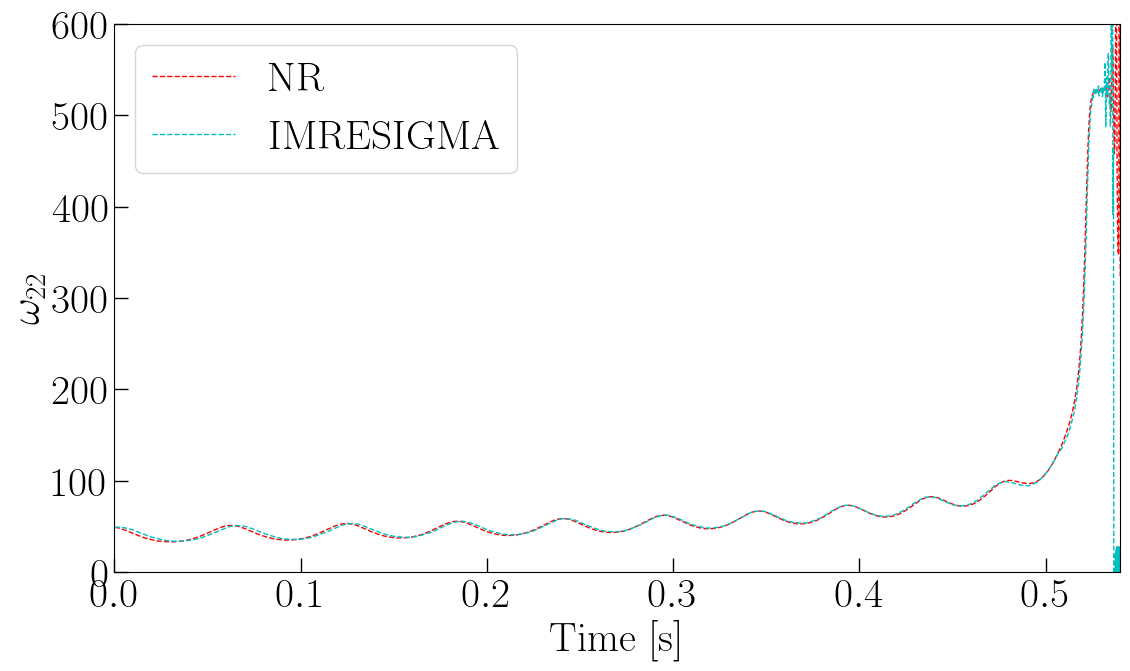

In [73]:

Optimal_val=[13.74, 0.300, 1.682]#Optimal_val #optimized value
M=30
q=3.000
m1=convert.mass1_from_mtotal_q(M,q)
m2=convert.mass2_from_mtotal_q(M,q)
distance=1.0
f_low=20
s1z = 0
s2z =0
sample_rate=4096
dt=1/sample_rate
conv=(lal.G_SI*lal.MSUN_SI*M/(distance*1e6*lal.PC_SI)/lal.C_SI/lal.C_SI)
modes=[(2,2),(2,-2)]#,(2,1),(2,-1),(3,2),(3,-2),(3,3),(3,-3),(4,4),(4,-4),(4,3),(4,-3)] # modes used for the computation
modes_to_use=[(2,2)]#, (2,1), (3,2),(3,3),(4,4),(4,3)]
iota=0
fref=Optimal_val[0]
e0 = Optimal_val[1]
l0 = Optimal_val[2]



h_str_NR=0
for mode in modes:
    
    ell, em=mode


    tref = 640.0  #check meta-data of NR simulations for tref


    hlm_NR=wf.get_mode(ell,em)
    #simulation = '/home/kaushik/NR_SIMS/'

    x1=hlm_NR[:,0]
    y1=hlm_NR[:,1]*(conv)    
    z1=hlm_NR[:,2]*(conv)

    plotband=np.where(x1>=tref)

    x1=x1[plotband]
    x1=x1-x1[0]
    y1=y1[plotband]    
    z1=z1[plotband]
    


    delta_t_NR = dt



    Ylm=waveform_modes.get_glm(ell, em, iota)        

    hlm_tot_NR=y1+1j*z1

    h_str_NR += (hlm_tot_NR*Ylm) # this is hlm*Ylm, and the for loop is summing over all the l,m modes.


delta_t_common=delta_t_NR
t=x1*M*MTSUN_SI

hp_NR=h_str_NR.real
hc_NR=-h_str_NR.imag

#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hp_NR,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hc_NR,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

hpVec_NR = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

itime=time.time()

hpl, hcr = eu.get_imr_enigma_waveform(m1, m2, fref, sample_rate, s1z, s2z, e0, l0, iota, 0, 
                                          distance, verbose=False,f_window_mr_transition=10,
                                          modes_to_use=modes_to_use,
                                          keep_f_mr_transition_at_center=True)


tlen1 = max(len(hpl), len(hpVec_NR))

tlen2 = max(len(hcr), len(hcVec_NR))

hpl.resize(tlen1)
hpVec_NR.resize(tlen1)

hcr.resize(tlen2)
hcVec_NR.resize(tlen2)

delta_f = 1.0 / hpl.duration
flen = tlen1//2 + 1

# delta_f = 1.0 / hcr.duration
# flen = tlen2//2 + 1

psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

m, i = match(hpl, hpVec_NR, psd=psd, low_frequency_cutoff=f_low)
mismatch = 1 - m

#print(m)


hplA, hpNR_A=pycbc.waveform.utils.coalign_waveforms(hpl,hpVec_NR,psd=None, low_frequency_cutoff=f_low)

hcrA, hcNR_A=pycbc.waveform.utils.coalign_waveforms(hcr,hcVec_NR,psd=None, low_frequency_cutoff=f_low)


tlen3 = max(len(hplA), len(hpNR_A))

hplA.resize(tlen3)
hpNR_A.resize(tlen3)

tlen4 = max(len(hcrA), len(hcNR_A))

hcrA.resize(tlen4)
hcNR_A.resize(tlen4)


#print(len(hplA),len(hpNR_A))

# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / hplA.duration
flen3 = tlen3//2 + 1
psd = aLIGOZeroDetHighPower(flen3, delta_f, f_low)

m, i = match(hplA, hpNR_A, psd=psd, low_frequency_cutoff=f_low)
mismatch = 1 - m

mt=m*100

print(mismatch*100)

amp_E=np.abs(hplA+1j*hcrA)
amp_NR=np.abs(hpNR_A+1j*hcNR_A)

f_E=pycbc.waveform.frequency_from_polarizations(hplA,hcrA)
f_NR=pycbc.waveform.frequency_from_polarizations(hpNR_A,hcNR_A)



%matplotlib inline
#plt.figure()
#plt.plot(hpl.sample_times,hpl,'b',label='IMRENIGMA')
#plt.plot(hpVec_NR.sample_times-hpVec_NR.sample_times[np.argmax(amp_NR)],hpVec_NR,'--r',label='SXS:BBH:1373')

#plt.plot(amp_NR.sample_times,amp_NR,'--r',linewidth=1,label='NR')
#plt.plot(amp_E.sample_times,amp_E,'c',linewidth=1,label='IMRESIGMA')

plt.plot(f_NR.sample_times,f_NR,'--r',label='NR',linewidth=1)
plt.plot(f_E.sample_times,f_E,'--c',label='IMRESIGMA',linewidth=1)


# plt.plot(hpNR_A.sample_times,hpNR_A,'--r',label='SXS:BBH:1364',linewidth=1)
# plt.plot(hplA.sample_times,hplA,'c',label='IMRESIGMAHM')
plt.xlabel('Time [s]')
plt.ylabel('$\mathcal{\omega}_{22}$')
plt.xlim(0,0.54)
plt.ylim(0,600)
plt.tick_params(axis='both', which='both', direction='in', width=1, length=10)
plt.legend(loc='upper left')
#plt.show()
#plt.savefig('IMRENIGMAvsSXS1364_freq_aligned_fref_{}_e0_{}_l0_{}_M_{}_match_{}_minISCO_22_4PN_11Feb24_new_v4.pdf'.format(Optimal_val[0],Optimal_val[1],Optimal_val[2],M, mt))
#plt.savefig('IMRENIGMAvsSXS1373_hplus_aligned_fref_{}_e0_{}_l0_{}_M_{}_match_{}_minISCO_22_4PN_11Feb24_new_v4.png'.format(Optimal_val[0],Optimal_val[1],Optimal_val[2],M, mt))
plt.tight_layout()
plt.savefig('ESIGMA_1373_freq.pdf',dpi=300)

# Mode-by-mode comparison

In [40]:
""" 
Our motivation/ goal is to find the value of parameters (f_ref, e0 ,l0) when the match between IMRESIGMAHM and 
NR simulation is maximized. To do this, we define a function calc_mismatch() which returns the mismatch between 
IMRESIGMAHM and  NR simulation. We then use this function and optimize it over (f_ref, e0 ,l0) to get the lowest
mismatch.

The optimization procedure can be done in two ways,

1. First, to get an idea of the region of the parameter values of (f_ref, e0 ,l0) for which the mismatch 
is tending towards a lower value, we create a set of 100 (or 1000 or 10000) random points of (f_ref, e0 ,l0).
We then use calc_mismatch() and compute mismatches for these 100 (or 1000 or 10000) points and find the point 
among these 100 (or 1000 or 10000) points for which the mismatch is minimum.

2. Next, we use that particular set of value as initial guess/start value in the optimization process.

We can skip to point number (2) if we have already identified the point where the mismatch is minimum.


Below are the values of the parameters used for the computation. Total mass, f_low, and inclination angle (iota)
is fixed to 40 M_sun, 10 Hz, and 60 degrees for all simulations, respectively. Value of q, s1z, s2z, t_ref depends 
on simulations and can be obtained from metadata of the simulation.

"""

M=40
q=3.000
m1=convert.mass1_from_mtotal_q(M,q)
m2=convert.mass2_from_mtotal_q(M,q)
distance=1
f_low=10
s1z =  2.42207546884e-06
s2z =  -1.56017535415e-07
sample_rate=4096
dt=1/sample_rate
conv=(lal.G_SI*lal.MSUN_SI*M/(distance*1e6*lal.PC_SI)/lal.C_SI/lal.C_SI) #conversion factor
# modes=[(2,2),(2,-2),(2,1),(2,-1),(3,2),(3,-2),(3,3),(3,-3),(4,4),(4,-4),(4,3),(4,-3)] # modes used for the computation
# modes_to_use=[(2,2), (2,1), (3,2),(3,3),(4,4),(4,3)]

modes=[(3,2),(3,-2)]#,(3,2),(3,-2),(3,3),(3,-3),(4,4),(4,-4),(4,3),(4,-3)] # modes used for the computation
modes_to_use=[(2,2),(3,2)]#, (3,2),(3,3),(4,4),(4,3)]

exclude_modes=[(2,2),(2,-2)]

iota=np.pi/3 # inclination angle


def calc_mismatch(frefel,verbose=False):
    fref,e,l=frefel
    h_str_NR=0
    for mode in modes:
        
        ell, em=mode
        
        
        tref = 380.0  #check meta-data of NR simulations for tref

        hlm_NR=wf.get_mode(ell,em)

        x1=hlm_NR[:,0]
        y1=hlm_NR[:,1]*(conv)    
        z1=hlm_NR[:,2]*(conv)

        plotband=np.where(x1>=tref)

        x1=x1[plotband]
        x1=x1-x1[0]
        y1=y1[plotband]    
        z1=z1[plotband]


        delta_t_NR = dt

               
        Ylm=waveform_modes.get_glm(ell, em, iota)        
    
        hlm_tot_NR=y1+1j*z1
        
        h_str_NR += (hlm_tot_NR*Ylm)
    

    delta_t_common=delta_t_NR
    t=x1*M*MTSUN_SI
    
    hp_NR=h_str_NR.real
    hc_NR=-h_str_NR.imag
    
    # interpolation to sample data at equispaced time points
    
    tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
    hp_NR_sample = interp1d(t,hp_NR,kind='cubic')
    hp_NR_int = hp_NR_sample(tVec_NR)
    hc_NR_sample = interp1d(t,hc_NR,kind='cubic')
    hc_NR_int = hc_NR_sample(tVec_NR)

    
    hpVec_NR = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
    hcVec_NR = TimeSeries(hc_NR_int,delta_t_common,epoch=0)
    
    itime=time.time()
    
    
    modes_dict=eu.get_imr_enigma_modes(m1, m2,f_lower=fref,sample_rate=sample_rate,spin1z=s1z,spin2z=s2z,
                       eccentricity=e,mean_anomaly=l,distance=distance, modes_to_use=modes_to_use,
                       f_window_mr_transition=10,keep_f_mr_transition_at_center=True)
    #print(modes_dict.keys())
    h_str_E=0
    for key in modes_dict.keys():
        if key not in exclude_modes:
            mode_pycbc = modes_dict[key]
            ell_e, em_e = key
            
            #print(ell_e, em_e)
            
            Ylm_E=waveform_modes.get_glm(ell_e, em_e, iota)        
    
            h_str_E += mode_pycbc*Ylm_E

            #print(f"Mode {key}: {mode_pycbc}")
    
    hplus_E=h_str_E.real()
    hcross_E=h_str_E.imag()
    
    #print(hplus_E.real())
    
    
    
#     hpl, hcr = eu.get_imr_enigma_waveform(m1, m2, fref, sample_rate, s1z, s2z, e, l, iota, 0, 
#                                           distance, verbose=False,f_window_mr_transition=10,
#                                           modes_to_use=modes_to_use,
#                                           keep_f_mr_transition_at_center=True)
    
    
    tlen = max(len(hplus_E.sample_times), len(hpVec_NR))

    hplus_E.resize(tlen)
    
    hpVec_NR.resize(tlen)

    # Generate the aLIGO ZDHP PSD
    
    delta_f = 1.0 / hplus_E.duration
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)
    
    m, i = match(hplus_E, hpVec_NR, psd=psd, low_frequency_cutoff=f_low)
    mismatch = 1 - m

    return(mismatch*100)

In [34]:
A=[32.364981413245431, 0.000185601902459, 6.283147923791927]
calc_mismatch(A)

17.900955922458074

In [33]:
import scipy.optimize as opt
bounds=[(11,100),(0.0,0.6),(0,2*np.pi)]
res = opt.minimize(calc_mismatch,x0=[32.364983599562564, 0.000176778327447, 6.283147988564383],bounds=bounds, 
                   method='nelder-mead')
optimal = res.x

formatted_optimal = ", ".join("{:.15f}".format(val) for val in optimal)
print(f"Optimal : [{formatted_optimal}]")

#print(f"Optimal : {optimal:.15f}")
print(f"value : {res.fun}")

Optimal : [32.364981413245431, 0.000185601902459, 6.283147923791927]
value : 17.900955925391614


In [10]:
ecc=np.random.uniform(0.0,0.01,1000)
freq=np.random.uniform(11,25,1000)
mean_ano=np.random.uniform(0,2*np.pi,1000)

pairs=[(f_v,e_v,ma_v) for f_v,e_v,ma_v in zip(freq,ecc,mean_ano)]

print(len(pairs))

1000


In [11]:
MM=[]
for pair in pairs:
    try:
        mv=calc_mismatch(pair)  
        #print(mv)
    except:
        mv=-1
    #print(pair)
    MM.append(mv)

print(MM)

[13.953769614323408, 14.66295347617229, 13.938336970074571, 14.144212389878241, 12.803125254933734, 13.053292598127141, 14.217134713217295, 12.777590050576038, 13.519486440933637, 12.836922318001797, 14.03666838679537, 14.773152035027092, 13.168138236530302, 13.900508514632048, 13.574321388707522, 13.176366147732587, 13.103329904492956, 12.889562806618693, 13.377874053659244, 13.87389642579625, 13.180529033119392, 14.471804538454059, 12.691524659124475, 13.791268099796493, 14.531898198618286, 13.220554933341411, 13.865628134151686, 13.446505493304539, 13.025819723281051, 13.661000994444294, 13.068071197507914, 13.41951043149896, 13.684398555091759, 13.259874006964745, 12.682877245530232, 14.175469256283668, 13.83755826743782, 12.851959937275936, 13.587465801248788, 13.033814050246306, 13.832725825863967, 14.225975968507287, 13.915709562290457, 13.141999758466483, 12.956280904587825, 12.859111700877545, 13.485394920177596, 14.507839071744977, 13.146597818131788, 14.475230104994875, 13.7

In [12]:
# Sample array containing both positive and negative values
arr = MM

# Step 1: Filter out positive values
positive_values = [x for x in arr if x > 0]

# Step 2: Check if the filtered list is empty
if not positive_values:
    print("No positive values found in the array.")
else:
    # Step 3: Find the minimum positive value
    min_positive_value = min(positive_values)
    print("Minimum positive value in the array:", min_positive_value)
    print("Position of min value:", positive_values.index(min_positive_value))

Minimum positive value in the array: 12.174044994975986
Position of min value: 712


In [13]:
for i in range(len(arr)):
    
    if arr[i]==positive_values[positive_values.index(min_positive_value)]:
        print(i)
        print(arr[i])
        print(pairs[i])

712
12.174044994975986
(23.90603729076538, 0.00540997864445455, 5.7804438599055405)


This mass= 20 is fine
This mass= 21 is fine
This mass= 22 is fine
This mass= 23 is fine
This mass= 24 is fine
This mass= 25 is fine
This mass= 26 is fine
This mass= 27 is fine
This mass= 28 is fine
This mass= 29 is fine
This mass= 30 is fine
This mass= 31 is fine
This mass= 32 is fine
This mass= 33 is fine
This mass= 34 is fine
This mass= 35 is fine
This mass= 36 is fine
This mass= 37 is fine
This mass= 38 is fine
This mass= 39 is fine
This mass= 40 is fine
This mass= 41 is fine
This mass= 42 is fine
This mass= 43 is fine
This mass= 44 is fine
This mass= 45 is fine
This mass= 46 is fine
This mass= 47 is fine
This mass= 48 is fine
This mass= 49 is fine
This mass= 50 is fine
This mass= 51 is fine
This mass= 52 is fine
This mass= 53 is fine
This mass= 54 is fine
This mass= 55 is fine
This mass= 56 is fine
This mass= 57 is fine
This mass= 58 is fine
This mass= 59 is fine
This mass= 60 is fine
This mass= 61 is fine
This mass= 62 is fine
This mass= 63 is fine
This mass= 64 is fine
This mass=

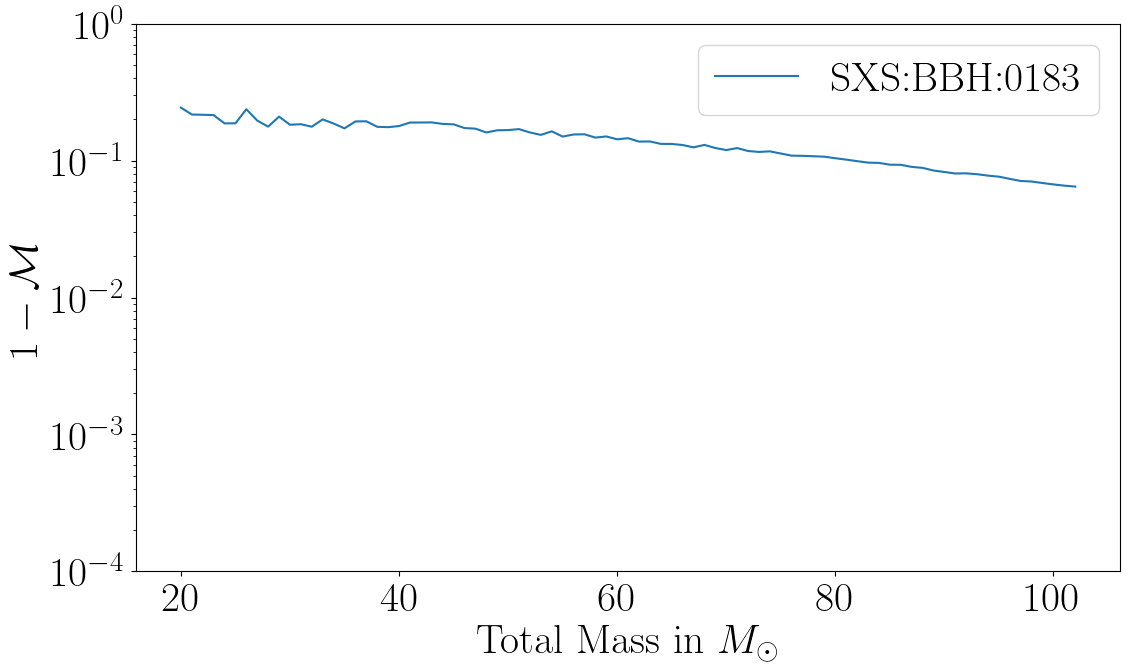

In [35]:
Optimal_val=[32.364981413245431, 0.000185601902459, 6.283147923791927] # optimized values

M_values=np.arange(20,121,1)
q=3.000
m1=convert.mass1_from_mtotal_q(M,q)
m2=convert.mass2_from_mtotal_q(M,q)
distance=1
f_low=10
s1z = 2.42207546884e-06
s2z = -1.56017535415e-07
#distance=1e6*lal.PC_SI
fref_val=Optimal_val[0]
e_val = Optimal_val[1]
l_val = Optimal_val[2]
sample_rate=4096
dt=1/sample_rate
# modes=[(2,2),(2,-2),(2,1),(2,-1),(3,2),(3,-2),(3,3),(3,-3),(4,4),(4,-4),(4,3),(4,-3)] # modes used for the computation
# modes_to_use=[(2,2), (2,1), (3,2),(3,3),(4,4),(4,3)]

modes=modes #,(3,2),(3,-2),(3,3),(3,-3),(4,4),(4,-4),(4,3),(4,-3)] # modes used for the computation
modes_to_use=modes_to_use #, (3,2),(3,3),(4,4),(4,3)]

exclude_modes=exclude_modes

iota=np.pi/3
m_original=40



Mvalues=[]

"""  
Below we check for which mass values we do not get a Desired frequency out of bound error. We store those
values of mass in Mvalues and use it to generate mismatch vs. total mass figure. 

"""

for mass in M_values:
    m1=convert.mass1_from_mtotal_q(mass,q)
    m2=convert.mass2_from_mtotal_q(mass,q)
    
    try:
        
        hpl, hcr = eu.get_imr_enigma_waveform(m1, m2, fref_val, sample_rate, s1z, s2z, e_val, l_val, iota, 0, 
                                              distance, verbose=False,f_window_mr_transition=10,
                                              modes_to_use=modes_to_use,
                                              keep_f_mr_transition_at_center=True)
        print("This mass= {} is fine".format(mass))
        Mvalues.append(mass)
    except:
        print("This mass= {} has problem".format(mass))
#print(Mvalues)
    


match_values=[]
mismatch_values=[]

mass_value=[]

for m_v in Mvalues:
    try:

        m1=convert.mass1_from_mtotal_q(m_v,q)
        m2=convert.mass2_from_mtotal_q(m_v,q)
        conv=(lal.G_SI*lal.MSUN_SI*m_v/(distance*1e6*lal.PC_SI)/lal.C_SI/lal.C_SI)
        h_str_NR=0
        mass_fac = m_original/m_v # mass_factor to be used to scale f_ref and time step (dt)

        #print(m_v)

        fref=fref_val*mass_fac # scaling f_ref
        e=e_val
        l=l_val

        dt_new= dt*mass_fac  # scaling time step



        for mode in modes:
            #print(mode)
            ell, em=mode


            tref = 380.0 #check meta-data of NR simulations for tref

            hlm_NR=wf.get_mode(ell,em)

            x1=hlm_NR[:,0]
            y1=hlm_NR[:,1]*(conv)    
            z1=hlm_NR[:,2]*(conv)


            plotband=np.where(x1>=tref)

            x1=x1[plotband]
            x1=x1-x1[0]
            y1=y1[plotband]    
            z1=z1[plotband]


            delta_t_NR = dt_new



            Ylm=waveform_modes.get_glm(ell, em, iota)        

            hlm_tot_NR=y1+1j*z1

            h_str_NR += (hlm_tot_NR*Ylm)


        delta_t_common=delta_t_NR
        t=x1*m_v*MTSUN_SI

        hp_NR=h_str_NR.real
        hc_NR=-h_str_NR.imag

        #### interpolation to sample data at equispaced time points

        tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
        hp_NR_sample = interp1d(t,hp_NR,kind='cubic')
        hp_NR_int = hp_NR_sample(tVec_NR)
        hc_NR_sample = interp1d(t,hc_NR,kind='cubic')
        hc_NR_int = hc_NR_sample(tVec_NR)


        hpVec_NR = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
        hcVec_NR = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

        #itime=time.time()

        s_rate=sample_rate/mass_fac  # scaling sample_rate

        modes_dict=eu.get_imr_enigma_modes(m1, m2,f_lower=fref,sample_rate=s_rate,spin1z=s1z,spin2z=s2z,
                           eccentricity=e,mean_anomaly=l,distance=distance, modes_to_use=modes_to_use,
                           f_window_mr_transition=10,keep_f_mr_transition_at_center=True)
        #print(modes_dict.keys())
        h_str_E=0
        for key in modes_dict.keys():
            if key not in exclude_modes:
                mode_pycbc = modes_dict[key]
                ell_e, em_e = key


                Ylm_E=waveform_modes.get_glm(ell_e, em_e, iota)        

                h_str_E += mode_pycbc*Ylm_E

                #print(f"Mode {key}: {mode_pycbc}")

        hplus_E=h_str_E.real()
        hcross_E=h_str_E.imag()


        tlen = max(len(hplus_E.sample_times), len(hpVec_NR))

        hplus_E.resize(tlen)

        hpVec_NR.resize(tlen)

        # Generate the aLIGO ZDHP PSD

        delta_f = 1.0 / hplus_E.duration
        flen = tlen//2 + 1
        psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

        m, i = match(hplus_E, hpVec_NR, psd=psd, low_frequency_cutoff=f_low)

    #     hpl, hcr = eu.get_imr_enigma_waveform(m1, m2, fref, s_rate, s1z, s2z, e, l, iota, 0, 
    #                                           distance, verbose=False,f_window_mr_transition=10,
    #                                           modes_to_use=modes_to_use,
    #                                           keep_f_mr_transition_at_center=True)


    #     tlen = max(len(hpl), len(hpVec_NR))

    #     hpl.resize(tlen)
    #     hpVec_NR.resize(tlen)

    #     # Generate the aLIGO ZDHP PSD
    #     delta_f = 1.0 / hpl.duration
    #     flen = tlen//2 + 1
    #     psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

    #     m, i = match(hpl, hpVec_NR, psd=psd, low_frequency_cutoff=f_low)
        mismatch = 1 - m
        print(m, mismatch)
        mm_values=mismatch
        m_values=m*100
        match_values.append(m_values)
        mismatch_values.append(mm_values)
        mass_value.append(m_v)
    except:
        print("this mass has a problem")

#print(Mvalues)
print(mismatch_values)
combined_array = np.column_stack((mass_value, mismatch_values))  # Combine A and B as columns

# Save the combined array to a .dat file
np.savetxt('mismatch_data_SXS0183_33_11Feb24.dat', combined_array, delimiter=',', fmt='%f')
plt.figure()
plt.plot(mass_value,mismatch_values, label='SXS:BBH:0183')
plt.yscale("log")
plt.ylim(1e-4,1e0)
plt.xlabel(r"Total Mass in $M_{\odot}$")
plt.ylabel(r"$1-\mathcal{M}$")
plt.legend()
plt.savefig("match_vs_totalMass_SXS0183_33_11Feb24.png")

17.873522412036447


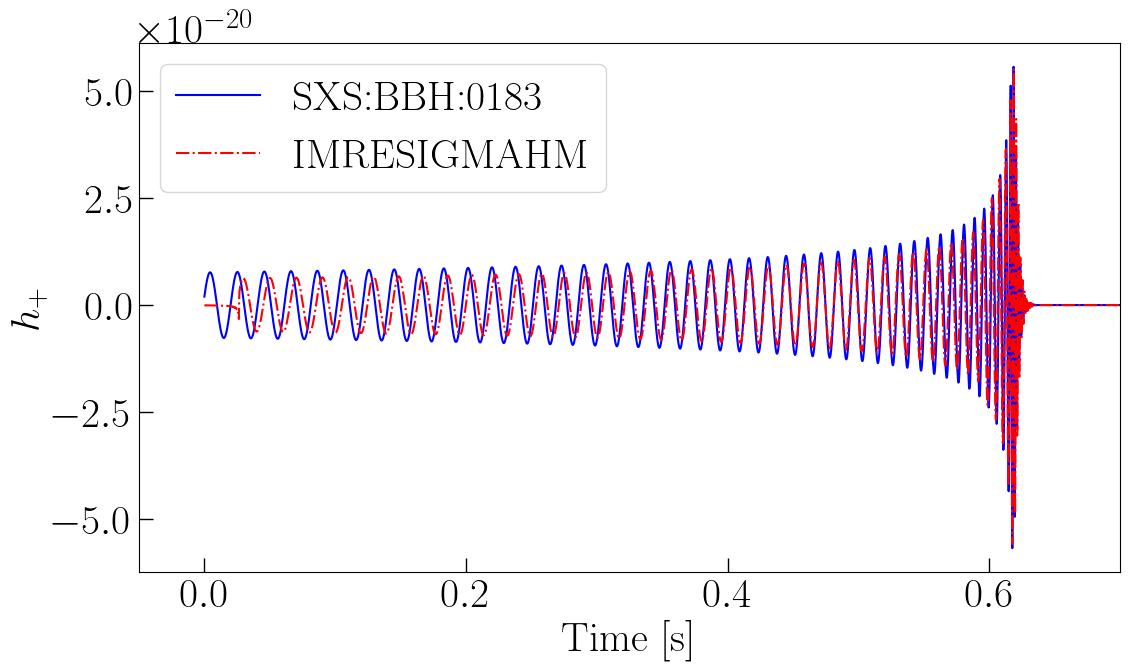

In [39]:
## PLOT STYLING
######################################################
linestyles = ['-', '--', '-.', '-x', '--o']
linecolors = ['r', 'g', 'b', 'k', 'm', 'y']
gmean = (5**0.5 + 1)/2.

# Figure settings
ppi=72.0
aspect=(5.**0.5 - 1) * 0.5
size=4.0 * 3# was 6
figsize=(size,aspect*size)
plt.rcParams.update({\
    'legend.fontsize':30, \
    #'text.fontsize':22,\
    'axes.labelsize':30,\
    'font.family':'serif',\
    'font.size':30,\
    'xtick.labelsize':30,\
    'ytick.labelsize':30,\
    'figure.subplot.bottom':0.2,\
    'figure.figsize':figsize, \
    'savefig.dpi': 300.0, \
    'figure.autolayout': True})
#####################################################

Optimal_val=[16.68,0.172,-0.181]#Optimal_val #optimized value
M=30
q=2.000
m1=convert.mass1_from_mtotal_q(M,q)
m2=convert.mass2_from_mtotal_q(M,q)
distance=1.0
f_low=10
s1z = 2.42207546884e-06
s2z = -1.56017535415e-07
sample_rate=4096
dt=1/sample_rate
conv=(lal.G_SI*lal.MSUN_SI*M/(distance*1e6*lal.PC_SI)/lal.C_SI/lal.C_SI)
# modes=[(2,2),(2,-2),(2,1),(2,-1),(3,2),(3,-2),(3,3),(3,-3),(4,4),(4,-4),(4,3),(4,-3)] # modes used for the computation
# modes_to_use=[(2,2), (2,1), (3,2),(3,3),(4,4),(4,3)]
iota=np.pi/3
fref=Optimal_val[0]
e0 = Optimal_val[1]
l0 = Optimal_val[2]

modes=modes #[(2,1),(2,-1)]#,(3,2),(3,-2),(3,3),(3,-3),(4,4),(4,-4),(4,3),(4,-3)] # modes used for the computation
modes_to_use=modes_to_use # [(2,2),(2,1)]#, (3,2),(3,3),(4,4),(4,3)]

exclude_modes=exclude_modes #[(2,2),(2,-2)]



h_str_NR=0
for mode in modes:
    
    ell, em=mode


    tref = 380.0  #check meta-data of NR simulations for tref


    hlm_NR=wf.get_mode(ell,em)

    x1=hlm_NR[:,0]
    y1=hlm_NR[:,1]*(conv)    
    z1=hlm_NR[:,2]*(conv)

    plotband=np.where(x1>=tref)

    x1=x1[plotband]
    x1=x1-x1[0]
    y1=y1[plotband]    
    z1=z1[plotband]
    


    delta_t_NR = dt



    Ylm=waveform_modes.get_glm(ell, em, iota)        

    hlm_tot_NR=y1+1j*z1

    h_str_NR += (hlm_tot_NR*Ylm) # this is hlm*Ylm, and the for loop is summing over all the l,m modes.


delta_t_common=delta_t_NR
t=x1*M*MTSUN_SI

hp_NR=h_str_NR.real
hc_NR=-h_str_NR.imag

#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hp_NR,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hc_NR,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

hpVec_NR = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
hcVec_NR = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

itime=time.time()

modes_dict=eu.get_imr_enigma_modes(m1, m2,f_lower=fref,sample_rate=sample_rate,spin1z=s1z,spin2z=s2z,
                       eccentricity=e,mean_anomaly=l,distance=distance, modes_to_use=modes_to_use,
                       f_window_mr_transition=10,keep_f_mr_transition_at_center=True)
#print(modes_dict.keys())
h_str_E=0
for key in modes_dict.keys():
    if key not in exclude_modes:
        mode_pycbc = modes_dict[key]
        ell_e, em_e = key


        Ylm_E=waveform_modes.get_glm(ell_e, em_e, iota)        

        h_str_E += mode_pycbc*Ylm_E

        #print(f"Mode {key}: {mode_pycbc}")

hplus_E=h_str_E.real()
hcross_E=h_str_E.imag()

# tlen = max(len(hplus_E.sample_times), len(hpVec_NR))

# hplus_E.resize(tlen)

# hpVec_NR.resize(tlen)

# # Generate the aLIGO ZDHP PSD

# delta_f = 1.0 / hplus_E.duration
# flen = tlen//2 + 1
# psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

# m, i = match(hplus_E, hpVec_NR, psd=psd, low_frequency_cutoff=f_low)



# hpl.resize(tlen1)
# hpVec_NR.resize(tlen1)

# hcr.resize(tlen2)
# hcVec_NR.resize(tlen2)

# delta_f = 1.0 / hpl.duration
# flen = tlen1//2 + 1

# # delta_f = 1.0 / hcr.duration
# # flen = tlen2//2 + 1

# psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

# m, i = match(hpl, hpVec_NR, psd=psd, low_frequency_cutoff=f_low)
#mismatch = 1 - m

#print(m)


hplA, hpNR_A=pycbc.waveform.utils.coalign_waveforms(hplus_E,hpVec_NR,psd=None, low_frequency_cutoff=f_low)

tlen3 = max(len(hplA), len(hpNR_A))

hplA.resize(tlen3)
hpNR_A.resize(tlen3)

#print(len(hplA),len(hpNR_A))

# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / hplA.duration
flen3 = tlen3//2 + 1
psd = aLIGOZeroDetHighPower(flen3, delta_f, f_low)

m, i = match(hplA, hpNR_A, psd=psd, low_frequency_cutoff=f_low)
mismatch = 1 - m

mt=m*100

print(mismatch*100)



plt.figure()
# plt.plot(hpl.sample_times,hpl,'b',label='IMRENIGMA')
# plt.plot(hpVec_NR.sample_times,hpVec_NR,'--r',label='SXS:BBH:1136')

plt.plot(hpNR_A.sample_times,hpNR_A,'b',label='SXS:BBH:0183')
plt.plot(hplA.sample_times,hplA,'-.r',label='IMRESIGMAHM')
plt.xlabel('Time [s]')
plt.ylabel(r'$h_{+}$')
plt.xlim(-0.05,0.7)
plt.tick_params(axis='both', which='both', direction='in', width=1, length=10)
plt.legend()
#plt.show()
plt.savefig('IMRENIGMAvsSXS0183_hplus_aligned_fref_{}_e0_{}_l0_{}_M_{}_match_{}_minISCO_33_4PN_11Feb24.png'.format(Optimal_val[0],Optimal_val[1],Optimal_val[2],M, mt))
plt.savefig('IMRENIGMAvsSXS0183_hplus_aligned_fref_{}_e0_{}_l0_{}_M_{}_match_{}_minISCO_33_4PN_11Feb24.pdf'.format(Optimal_val[0],Optimal_val[1],Optimal_val[2],M, mt))

Exception: File `'Model_22_Updated.ipynb'` not found.